# Data Augmentation and Gradient Penalties

### Doing More With Less - Matchue

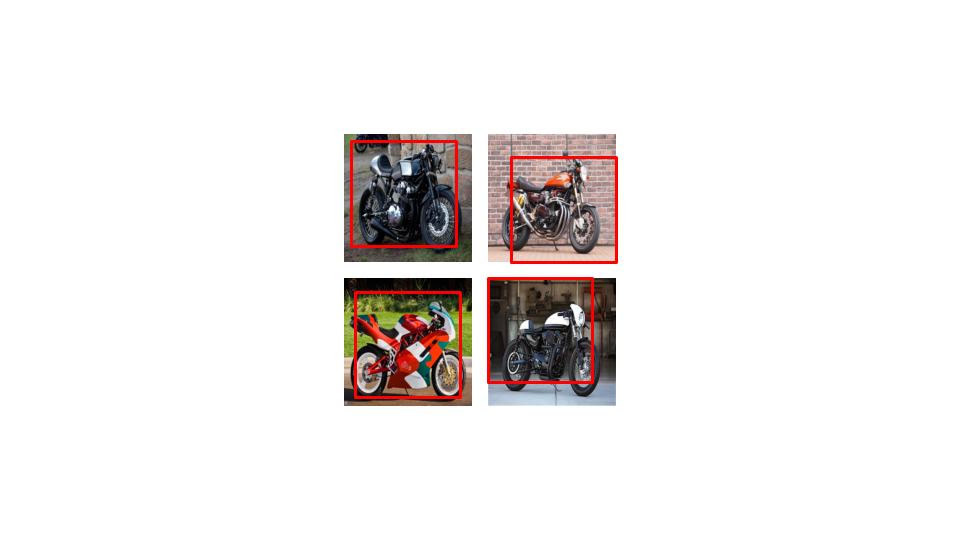

In [1]:
#Import packages
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

from keras.layers import *
from keras.models import *
from keras.datasets import mnist
from keras.optimizers import RMSprop
import keras.backend as K

Using TensorFlow backend.


1922 images.


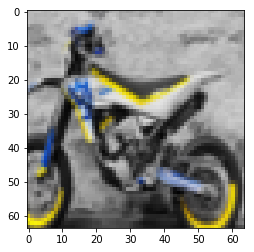

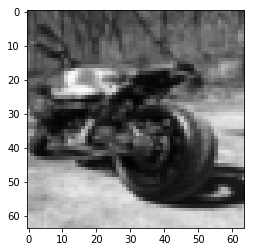

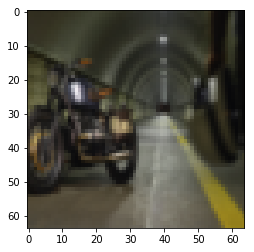

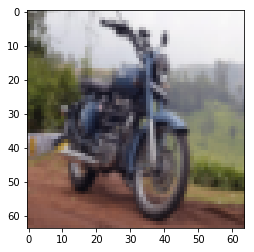

In [2]:
#Hyperparameters and statistics
batch_size = 64
iterations = 50000

d_loss = []
g_loss = []
gp_loss = []

#Import data
x_train = np.load('motorbikes80.npy')

#Normalize data
x_train = x_train.astype('float32') / 255.0

#Check number of images
print(str(x_train.shape[0]) + " images.")


crop = np.random.randint(0, 16, [2])
image_indices = np.random.randint(0, x_train.shape[0] - 1, [4])
real_images = x_train[image_indices, crop[0]:crop[0]+64, crop[1]:crop[1]+64]

for i in range(4):
    plt.figure(i)
    plt.imshow(real_images[i])

plt.show()

In [3]:
def r1_gradient_penalty(y_true, y_pred, samples):
    #Get gradients of pixel values (first layer)
    gradients = K.gradients(y_pred, samples)[0]
    
    #Get norm squared: ||grad||^2
    gradients_sqr = K.square(gradients)
    gradient_norm = K.sum(gradients_sqr, axis = [1, 2, 3])
    
    #Return average over batch
    return K.mean(gradient_norm)

In [4]:
def g_block(input_tensor, filters):
    out = UpSampling2D()(input_tensor)
    out = Conv2D(filters, 3, padding = 'same')(out)
    out = Activation('relu')(out)
    return out

In [5]:
def d_block(input_tensor, filters):
    out = Conv2D(filters, 3, padding = 'same')(input_tensor)
    out = LeakyReLU(0.2)(out)
    out = AveragePooling2D()(out)
    return out

In [6]:
#Latent input
latent_input = Input([64])

#Reshape to 4x4x64
x = Dense(4*4*64, activation = 'relu')(latent_input)
x = Reshape([4, 4, 64])(x)

#Size: 4x4x64
x = g_block(x, 64)

#Size: 8x8x64
x = g_block(x, 32)

#Size: 16x16x32
x = g_block(x, 16)

#Size: 32x32x16
x = g_block(x, 8)

#Size: 64x64x8, make RGB with values between 0 and 1
image_output = Conv2D(3, 1, padding = 'same', activation = 'sigmoid')(x)

#Make Model
generator = Model(inputs = latent_input, outputs = image_output)

#Model Summary
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              66560     
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 64)          0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
activation_1 (Activation)    (None, 8, 8, 64)          0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 16, 16, 64)        0         
__________

In [7]:
#Image input
image_input = Input([64, 64, 3])

#Size: 64x64x3
x = d_block(image_input, 8)

#Size: 32x32x8
x = d_block(x, 16)

#Size: 16x16x16
x = d_block(x, 32)

#Size: 8x8x32
x = d_block(x, 64)

#Size: 4x4x64
x = Conv2D(64, 3, padding = 'same')(x)
x = LeakyReLU(0.2)(x)
x = Flatten()(x)

#1-dimensional Neural Network
class_output = Dense(1)(x)

#Make Model
discriminator = Model(inputs = image_input, outputs = class_output)

#Model summary
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 8)         224       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 8)         0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 16)        1168      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 16)        0         
_________________________________________________________________
average_pooling2d_2 (Average (None, 16, 16, 16)        0         
__________

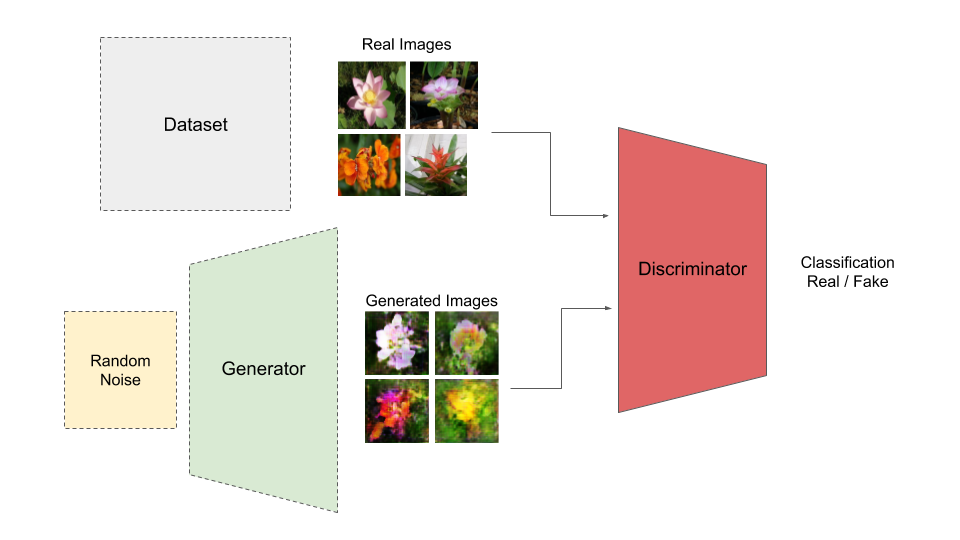

In [8]:
#Build network to train the discriminator.
#Discriminator will train, but Generator won't train.
for layer in discriminator.layers:
    layer.trainable = True
    
for layer in generator.layers:
    layer.trainable = False
    
    
    
#Get real image
real_image = Input([64, 64, 3])

#Discriminator classifies
validity_real = discriminator(real_image)



#Get latent input
latent_input = Input([64])

#Generate an image
fake_image = generator(latent_input)

#Discriminator classifies
validity_fake = discriminator(fake_image)


#Create Gradient Penalty Loss with Real Samples
partial_gp = partial(r1_gradient_penalty, samples = real_image)

#Create and compile the model
DiscriminatorModel = Model(inputs = [real_image, latent_input], outputs = [validity_real, validity_fake, validity_real])

DiscriminatorModel.compile(optimizer = RMSprop(lr = 0.0002),
                           loss = ['mean_squared_error', 'mean_squared_error', partial_gp],
                           loss_weights = [1, 1, 10])

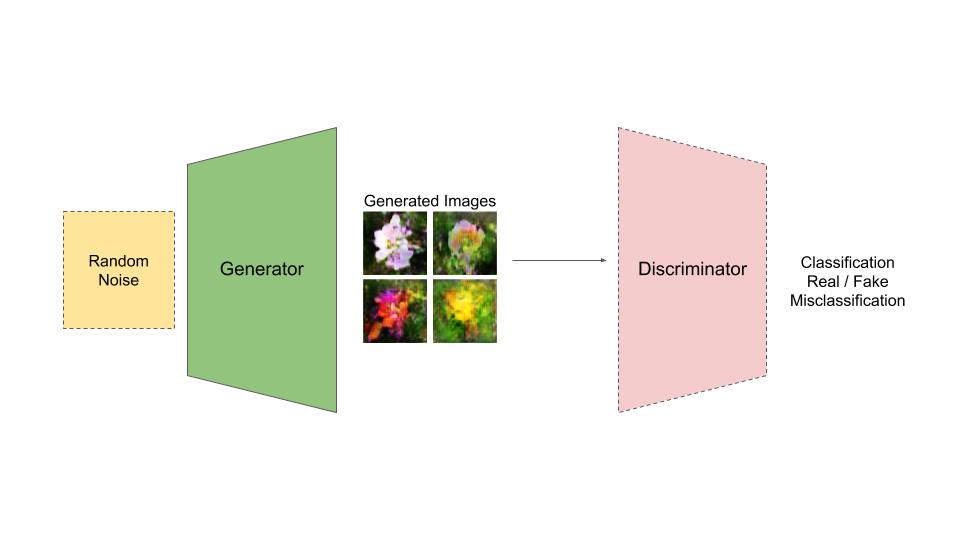

In [9]:
#Build network to train the generator.
#Discriminator won't train, but Generator will train.
for layer in discriminator.layers:
    layer.trainable = False
    
for layer in generator.layers:
    layer.trainable = True

#Get latent input
latent_input = Input([64])

#Generate an image
fake_image = generator(latent_input)

#Discriminator classifies
validity = discriminator(fake_image)

#Create and compile the model
GeneratorModel = Model(inputs = latent_input, outputs = validity)

GeneratorModel.compile(optimizer = RMSprop(lr = 0.0002), loss = 'mean_squared_error')

In [10]:
#Train the models in a loop
for i in range(iterations):
    
    print('\rIteration ' + str(i), end = '')
    
    #Get labels
    real_labels = np.ones([batch_size, 1])
    fake_labels = np.zeros([batch_size, 1])
    dummy_labels = np.ones([batch_size, 1])
    
    #Train discriminator
    #Get images and latent vectors
    crop = np.random.randint(0, 16, [2])
    image_indices = np.random.randint(0, x_train.shape[0] - 1, [batch_size])
    real_images = x_train[image_indices, crop[0]:crop[0]+64, crop[1]:crop[1]+64]
    latent_vectors = np.random.normal(0.0, 1.0, [batch_size, 64])
    
    #Train
    loss = DiscriminatorModel.train_on_batch([real_images, latent_vectors], [real_labels, fake_labels, dummy_labels])
    d_loss.append(loss[1]/2 + loss[2]/2)
    gp_loss.append(loss[3])
    
    #Train generator
    #Get latent vectors
    latent_vectors = np.random.normal(0.0, 1.0, [batch_size, 64])
    
    #Train using opposite labels
    loss = GeneratorModel.train_on_batch(latent_vectors, real_labels)
    g_loss.append(loss)

Iteration 49999

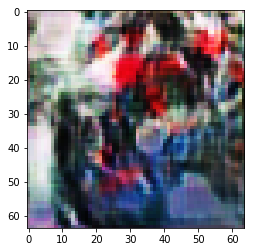

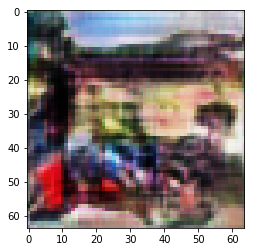

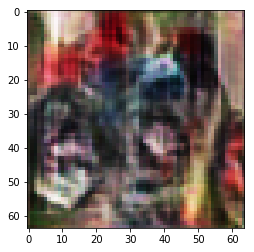

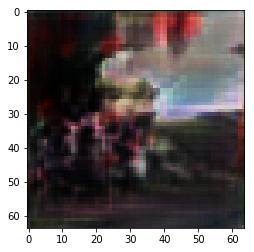

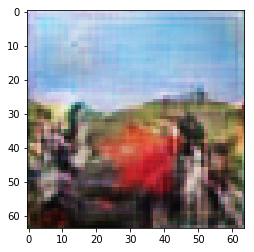

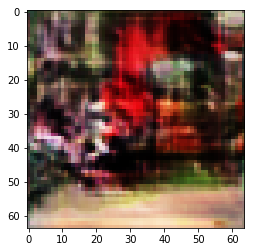

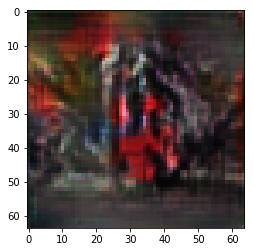

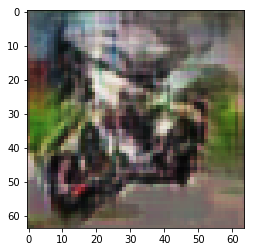

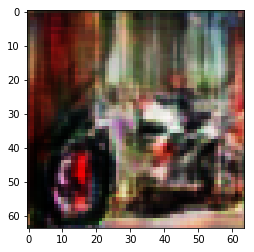

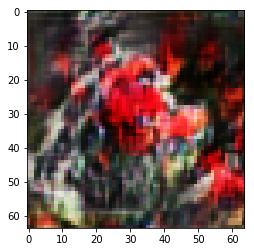

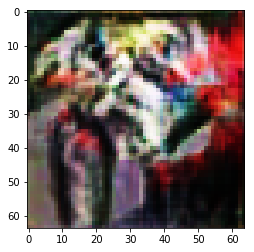

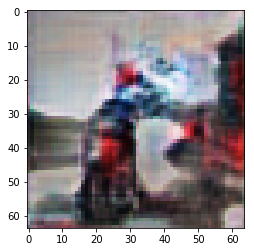

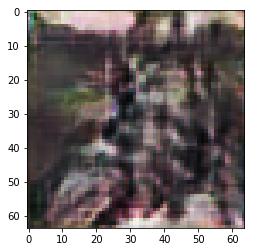

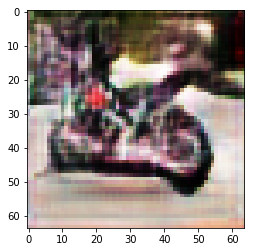

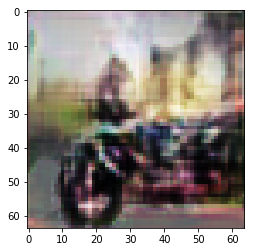

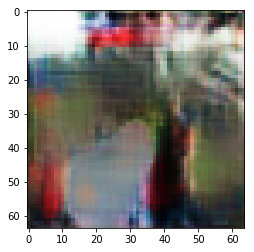

In [11]:
#Show samples
latent_vectors = np.random.normal(0.0, 1.0, [16, 64])
fake_images = generator.predict(latent_vectors)

for i in range(16):
    plt.figure(i)
    plt.imshow(fake_images[i])

plt.show()

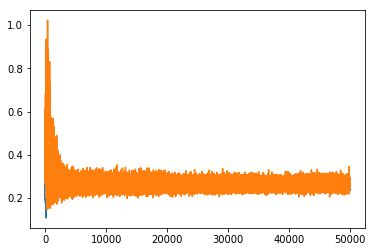

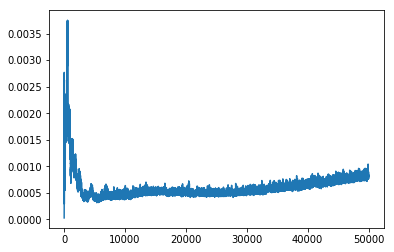

In [12]:
#Plot losses
plt.plot(d_loss)
plt.plot(g_loss)
plt.show()

plt.plot(gp_loss)
plt.show()

In [13]:
from PIL import Image
latent_vectors = np.random.normal(0.0, 1.0, [100, 64])
fake_images = generator.predict(latent_vectors)

for i in range(100):
    x = Image.fromarray(np.uint8(fake_images[i]*255))
    x.save("Results/image-" + str(i) + ".png")